In [1]:
import torch
import numpy as np
import models
import data
import utils
from matplotlib import pyplot as plt

In [2]:
!ls logs/oct/train.py-CIFAR10_VGG16/test_it/width64_all_DS-11-10-22:03:48

width64_all_DS-11-10-22:03:48


In [3]:
"--dir=logs",
data_path="./data/"
dataset="CIFAR10"
transform="VGG"
model="VGG16"
batch_size=128
num_workers=4
use_test=False
"--save_freq=200",
"--print_freq=5",
"--epochs=200",
"--wd=0.001",
"--lr=0.05",
dropout=0.5
"--comment=width64",
"--seed=25477",
width=64
"--num-nets=8",
"--num-exps=5"

loaders, num_classes = data.loaders(dataset,
                                    data_path,
                                    batch_size,
                                    num_workers,
                                    transform,
                                    use_test
                                    )

architecture = getattr(models, model)()
architecture.kwargs["k"] = width
if "VGG" in model or "WideResNet" in model:
    architecture.kwargs["p"] = dropout
model = architecture.base(num_classes=num_classes, **architecture.kwargs)

Files already downloaded and verified
Using train (45000)
Using validation (5000)


In [7]:
def predictions_cpu(test_loader, model, **kwargs):
    model.eval()
    preds = []
    targets = []
    for input, target in test_loader:
        output = model(input, **kwargs)
        probs = output #F.softmax(output, dim=1)
        preds.append(probs.cpu().data.numpy())
        targets.append(target.numpy())
    return np.vstack(preds), np.concatenate(targets)

In [8]:
work_dir = 'logs/oct/train.py-CIFAR10_VGG16/test_it/width64_all_DS-11-10-22:03:48/'

for num_model in range(8):
    saved_data = torch.load(work_dir+f'model_run{num_model}.cpt', map_location='cpu')
    model.load_state_dict(saved_data['model_state'])

    predictions_logits, targets = predictions_cpu(loaders['test'], model)
    np.save(work_dir + 'predictions_run%d' % num_model, predictions_logits)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/oct/train.py-CIFAR10_VGG16/test_it/width64_all_DS-11-10-22:03:48/model_run0.cpt'

In [41]:
a = ({'idth64_one_model_all_DS': [[0.2230979779897145]], 'idth64_jikko': [[0.28038630706529777, 0.2883417261518423, 0.28219523896055054, 0.29111318865708463, 0.28146418453354227, 0.2891230989086065, 0.28216981876345365], [0.255760371726635, 0.25993916409693174, 0.25596152570869246], [0.24390218026228017, 0.24406948981762872], [0.24108480964405793], [0.24109533119023102], [0.24114732810022435], [0.24117285270063493]]}, {'idth64_one_model_all_DS': [[0.30392202957640374]], 'idth64_jikko': [[0.3856634381029603, 0.3939126744515373, 0.384885129563116, 0.40147924065915885, 0.3817979879040634, 0.3939900846008901, 0.3831623040655162], [0.3081009506438151, 0.31582169267967586, 0.30580502661077397], [0.27938810388509344, 0.27828471509318353], [0.2707527364725438], [0.2707527364725438], [0.2707527364725438], [0.2707527364725438]]}, {'idth64_one_model_all_DS': [[0.931]], 'idth64_jikko': [[0.9114, 0.9088, 0.9104, 0.9086, 0.911, 0.911, 0.9102], [0.916, 0.9172, 0.9182], [0.9184, 0.917], [0.9188], [0.9188], [0.9188], [0.9188]]}, {'idth64_one_model_all_DS': [[[1.892968750000002, 1.9062500000000022, 1.9078125000000021, 1.891406250000002, 1.888281250000002, 1.910156250000002, 1.9546875000000021, 1.8421875000000019, 1.9000000000000021, 1.9000000000000021]]], 'idth64_jikko': [[[1.919531250000002, 1.9445312500000023, 2.005468750000002, 1.854687500000002, 1.955468750000002, 1.908593750000002, 1.9273437500000021, 1.9367187500000023, 1.875781250000002, 1.9859375000000021], [1.924218750000002, 1.924218750000002, 1.9585937500000021, 1.8890625000000019, 1.917187500000002, 1.9312500000000021, 1.908593750000002, 1.9398437500000023, 1.8984375000000022, 1.9492187500000022], [1.9023437500000022, 1.9375000000000022, 1.8960937500000021, 1.9429687500000024, 1.917187500000002, 1.921875000000002, 1.8890625000000019, 1.9492187500000022, 1.9546875000000021, 1.884375000000002], [1.890625000000002, 1.9929687500000022, 1.928125000000002, 1.9585937500000021, 1.9304687500000022, 1.956250000000002, 1.8960937500000021, 1.9875000000000023, 1.9312500000000021, 1.955468750000002], [1.9046875000000023, 1.9117187500000021, 1.916406250000002, 1.9000000000000021, 1.885937500000002, 1.928906250000002, 1.9468750000000021, 1.865625000000002, 1.878125000000002, 1.9351562500000021], [1.901562500000002, 1.948437500000002, 1.9367187500000023, 1.9140625000000022, 1.8679687500000022, 1.9789062500000023, 1.9531250000000022, 1.8960937500000021, 1.928906250000002, 1.921875000000002], [1.928906250000002, 1.890625000000002, 1.9156250000000021, 1.9046875000000023, 1.9234375000000021, 1.896875000000002, 1.9531250000000022, 1.864062500000002, 1.8984375000000022, 1.921875000000002]], [[1.7109375000000018, 1.6546875000000019, 1.6875000000000018, 1.6804687500000017, 1.6734375000000017, 1.6937500000000019, 1.6859375000000019, 1.6820312500000016, 1.640625000000002, 1.7250000000000019], [1.7101562500000016, 1.6937500000000019, 1.6789062500000016, 1.7257812500000018, 1.6609375000000015, 1.739062500000002, 1.7164062500000017, 1.6882812500000017, 1.6687500000000015, 1.7343750000000018], [1.6640625000000018, 1.6796875000000018, 1.641406250000002, 1.7015625000000019, 1.6875000000000018, 1.6562500000000018, 1.7031250000000018, 1.640625000000002, 1.6562500000000018, 1.6875000000000018]], [[1.5859375000000018, 1.5585937500000018, 1.5960937500000019, 1.5468750000000016, 1.5429687500000016, 1.602343750000002, 1.5546875000000018, 1.5898437500000018, 1.5359375000000015, 1.6078125000000019], [1.5523437500000017, 1.5796875000000017, 1.5359375000000015, 1.5960937500000019, 1.5640625000000017, 1.567968750000002, 1.6218750000000017, 1.5062500000000014, 1.5515625000000015, 1.5804687500000016]], [[1.5484375000000017, 1.5000000000000013, 1.5437500000000015, 1.5062500000000014, 1.5117187500000016, 1.5375000000000014, 1.5078125000000013, 1.5414062500000014, 1.5429687500000016, 1.5070312500000014]], [[1.5046875000000015, 1.5437500000000015, 1.5492187500000016, 1.5007812500000013, 1.5257812500000014, 1.5234375000000013, 1.5398437500000015, 1.5085937500000015, 1.5507812500000016, 1.4976562500000012]], [[1.5312500000000013, 1.5179687500000016, 1.5664062500000018, 1.4804687500000016, 1.5015625000000012, 1.5468750000000016, 1.5125000000000015, 1.5375000000000014, 1.5453125000000014, 1.5039062500000013]], [[1.5023437500000014, 1.5453125000000014, 1.5539062500000016, 1.4937500000000012, 1.4937500000000012, 1.5546875000000018, 1.5445312500000015, 1.5039062500000013, 1.5515625000000015, 1.4953125000000012]]]})

In [44]:
nlls_c, nlls_nc, accs_global, temps_global = a

In [46]:
accs_global

{'idth64_one_model_all_DS': [[0.931]],
 'idth64_jikko': [[0.9114, 0.9088, 0.9104, 0.9086, 0.911, 0.911, 0.9102],
  [0.916, 0.9172, 0.9182],
  [0.9184, 0.917],
  [0.9188],
  [0.9188],
  [0.9188],
  [0.9188]]}

In [1]:

leng = 10
for l in range(1, leng+1):
    print('start process:', l)
    accs, c_nlls, nc_nlls, temps = [], [], [], []
    if l < leng // 2 + 2:
        count = leng//l
        for j in range(count):
            print('fun from', j*l, 'to', (j+1)*l)
    else:
        break

start process: 1
fun from 0 to 1
fun from 1 to 2
fun from 2 to 3
fun from 3 to 4
fun from 4 to 5
fun from 5 to 6
fun from 6 to 7
fun from 7 to 8
fun from 8 to 9
fun from 9 to 10
start process: 2
fun from 0 to 2
fun from 2 to 4
fun from 4 to 6
fun from 6 to 8
fun from 8 to 10
start process: 3
fun from 0 to 3
fun from 3 to 6
fun from 6 to 9
start process: 4
fun from 0 to 4
fun from 4 to 8
start process: 5
fun from 0 to 5
fun from 5 to 10
start process: 6
fun from 0 to 6
start process: 7


In [4]:
with open('gather_logs/gather_nlls.py-setup2_optimal_CIFAR10_VGG16_regtest_run-11-15-18:25:38/output.out', 'r') as fr:
    l = fr.readlines()

In [5]:
import json
import yaml

In [6]:
nlls_c_or       = yaml.safe_load(l[-1].split('}')[0][1:] + '}')
nlls_nc_or      = yaml.safe_load(l[-1].split('}')[1][2:] + '}')
accs_global_or  = yaml.safe_load(l[-1].split('}')[2][2:] + '}')
temps_global_or = yaml.safe_load(l[-1].split('}')[3][2:] + '}')
boot_name, all_name = nlls_c_or.keys()

In [9]:
len(nlls_c_or[boot_name]), len(nlls_c_or[all_name])

(28, 30)

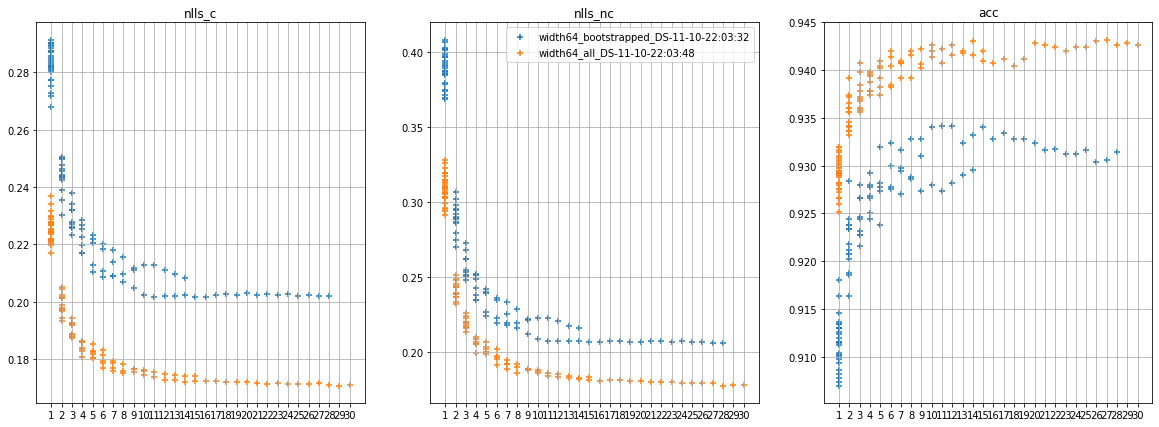

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))

major_ticks = np.arange(1, max(len(nlls_c_or[boot_name]), len(nlls_c_or[all_name])) + 1, 1)

a = ax1.scatter([j + 1 for j, sl in enumerate(nlls_c_or[boot_name]) for i in sl],
            [i for sl in nlls_c_or[boot_name] for i in sl], marker='+')
b = ax1.scatter([j + 1 for j, sl in enumerate(nlls_c_or[all_name]) for i in sl],
            [i for sl in nlls_c_or[all_name] for i in sl], marker='+')
ax1.grid()
ax1.set_xticks(major_ticks)
ax1.set_title('nlls_c')
ax2.scatter([j + 1 for j, sl in enumerate(nlls_nc_or[boot_name]) for i in sl],
            [i for sl in nlls_nc_or[boot_name] for i in sl], marker='+', label='w' + boot_name)
ax2.scatter([j + 1 for j, sl in enumerate(nlls_nc_or[all_name]) for i in sl],
            [i for sl in nlls_nc_or[all_name] for i in sl], marker='+', label='w' + all_name)
ax2.grid()
ax2.set_xticks(major_ticks)
ax2.set_title('nlls_nc')
ax3.scatter([j + 1 for j, sl in enumerate(accs_global_or[boot_name]) for i in sl],
            [i for sl in accs_global_or[boot_name] for i in sl], marker='+')
ax3.scatter([j + 1 for j, sl in enumerate(accs_global_or[all_name]) for i in sl],
            [i for sl in accs_global_or[all_name] for i in sl], marker='+')
ax3.grid()
ax3.set_xticks(major_ticks)
ax3.set_title('acc')


# fig.suptitle('w' + a1)

ax2.legend()
plt.show()

In [12]:
import os
from gather_nlls_module import ComputeNLLs

def softmax(x):
    e_x = np.exp(x - np.reshape(np.max(x,axis=1),(-1,1)))
    return e_x / np.reshape(e_x.sum(axis=1),(-1,1))

def compute_nlls(self, logdirs, model_name, num_classes, setting,\
                        plen=1, reverse_order=False, max_std=5, max_enslen=10**5):
    loaders, num_classes = data.loaders(
                "CIFAR%d"%num_classes,
                "./data/",
                128,
                1,
                "%s_noDA"%("VGG" if model_name == "VGG16" else "ResNet"),
                # True
            )
    targets = np.array(loaders["test"].dataset.targets)

    ll = 1 if not reverse_order else -1
    if not type(logdirs) == list:
        logdirs = [logdirs]
    preds = {}
    for logdir in logdirs:
        for i, p_folder in enumerate(sorted(os.listdir(logdir))):
            if not "ipynb" in p_folder and not "run" in p_folder:
                p_str = p_folder
                x = p_folder.find("_")
                # if x > 0:
                #     p = float(p_folder[plen:x])
                # else:
                p = p_folder[plen:]
                exp_folders = sorted(os.listdir(logdir+"/"+p_folder))
                if not p in preds:
                    preds[p] = []
                for exp_folder in exp_folders:
                    if not "ipynb" in logdir+"/"+p_folder+"/"+exp_folder and\
                    not "run" in logdir+"/"+p_folder+"/"+exp_folder and\
                    not "skipsameseed" in exp_folder:
                        for f in sorted(os.listdir(logdir+"/"+p_folder+"/"+exp_folder))[::ll]:
                            if "predictions" in f:
                                fn = logdir+"/"+p_folder+"/"+exp_folder+"/"+f
                                if self.setup == 1:
                                    ppp = softmax(np.float64(np.load(fn)))
                                else:
                                    ppp = np.float64(np.load(fn))
                                acc = np.equal(np.argmax(ppp, axis=1), targets).mean()
                                if acc > 0.15:
                                    preds[p].append(ppp[:, :, None] if self.setup==1\
                                                    else ppp)
                                else:
                                    print(exp_folder+"/"+f, "is bad!")
    return preds, targets

In [13]:
setup = 2
regime = 'optimal'
model = 'VGG16'
dataset = 10
setting = 'reg'

temps = np.arange(0.5, 3.2, 0.05)
logdirs = ["logs/oct/train.py-CIFAR10_VGG16/test_it",]

computer = ComputeNLLs(setup=setup, regime=regime, temps=temps)
preds, targets = compute_nlls(computer, logdirs, model, dataset, setting, plen=1, reverse_order=False, max_std=10**5, max_enslen=10**5)

Files already downloaded and verified
Using train (45000)
Using validation (5000)


In [16]:
max_enslen = 100
max_std = 5
nlls_c = []
nlls_nc = []
accs_global = []
temps_global = []
saturation_point = 17

ps = sorted(preds.keys())[::-1]
if setup == 1 or regime == "optimal":
    leng = min(len(preds[boot_name]), max_enslen, len(preds[all_name]) - saturation_point)

    for l in range(1, leng+1):
        print(l)
        accs, c_nlls, nc_nlls, temps = [], [], [], []
        count = min(len(preds[boot_name])//l, max_std)
        for j in range(count):
            ret = computer.get_ens_quality1_2o(preds[all_name][:saturation_point] + preds[boot_name][j*l:(j+1)*l], targets)
            if regime == "optimal":
                acc, nc_nll, c_nll, predictions, temps_ = ret
            else: # "grid"
                acc, c_nll, predictions = ret
            if acc > 0.15:
                accs.append(acc)
                c_nlls.append(c_nll)
                if regime == "optimal":
                    nc_nlls.append(nc_nll)
                    temps.append(temps_)

        nlls_c.append(c_nlls)
        nlls_nc.append(nc_nlls)
        accs_global.append(accs)
        temps_global.append(temps)

1
2
3
4
5
6
7
8
9
10
11
12
13


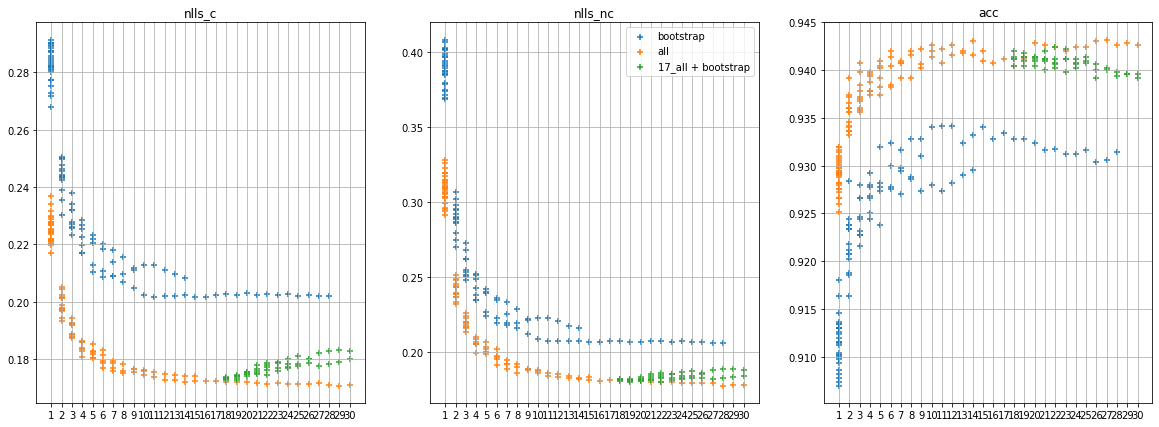

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 7))

major_ticks = np.arange(1, max(len(nlls_c_or[boot_name]), len(nlls_c_or[all_name])) + 1, 1)

ax1.scatter([j + 1 for j, sl in enumerate(nlls_c_or[boot_name]) for i in sl],
            [i for sl in nlls_c_or[boot_name] for i in sl], marker='+')
ax1.scatter([j + 1 for j, sl in enumerate(nlls_c_or[all_name]) for i in sl],
            [i for sl in nlls_c_or[all_name] for i in sl], marker='+')
ax1.scatter([j + 1 + saturation_point for j, sl in enumerate(nlls_c) for i in sl],
            [i for sl in nlls_c for i in sl], marker='+')
ax1.grid()
ax1.set_xticks(major_ticks)
ax1.set_title('nlls_c')
ax2.scatter([j + 1 for j, sl in enumerate(nlls_nc_or[boot_name]) for i in sl],
            [i for sl in nlls_nc_or[boot_name] for i in sl], marker='+', label='bootstrap')
ax2.scatter([j + 1 for j, sl in enumerate(nlls_nc_or[all_name]) for i in sl],
            [i for sl in nlls_nc_or[all_name] for i in sl], marker='+', label='all')
ax2.scatter([j + 1 + saturation_point for j, sl in enumerate(nlls_nc) for i in sl],
            [i for sl in nlls_nc for i in sl], marker='+', label=str(saturation_point) + '_all + bootstrap')
ax2.grid()
ax2.set_xticks(major_ticks)
ax2.set_title('nlls_nc')
ax3.scatter([j + 1 for j, sl in enumerate(accs_global_or[boot_name]) for i in sl],
            [i for sl in accs_global_or[boot_name] for i in sl], marker='+')
ax3.scatter([j + 1 for j, sl in enumerate(accs_global_or[all_name]) for i in sl],
            [i for sl in accs_global_or[all_name] for i in sl], marker='+')
ax3.scatter([j + 1 + saturation_point for j, sl in enumerate(accs_global) for i in sl],
            [i for sl in accs_global for i in sl], marker='+')
ax3.grid()
ax3.set_xticks(major_ticks)
ax3.set_title('acc')


# fig.suptitle('w' + a1)

ax2.legend()
plt.show()